In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn

import warnings
warnings.simplefilter("ignore")

In [25]:
accs = pd.read_csv("accuracies.csv")
accs

,k,knn_pca_auroc,knn_pca_acc,rf_pca_auroc,rf_pca_acc,lr_auroc,lr_acc
0,1,0.657810,0.508475,0.731969,0.569492,0.711949,0.532203
1,2,0.653085,0.522034,0.682164,0.508475,0.705178,0.525424
2,3,0.648103,0.515254,0.675804,0.450847,0.707109,0.532203
3,4,0.650041,0.498305,0.667644,0.457627,0.691753,0.505085
4,5,0.647393,0.488136,0.684461,0.491525,0.679025,0.484746
...,...,...,...,...,...,...,...
95,96,0.611992,0.450847,0.677204,0.491525,0.624920,0.423729
96,97,0.611992,0.450847,0.678360,0.494915,0.624920,0.423729
97,98,0.611992,0.450847,0.677380,0.508475,0.624920,0.423729
98,99,0.611992,0.450847,0.677253,0.505085,0.624920,0.423729


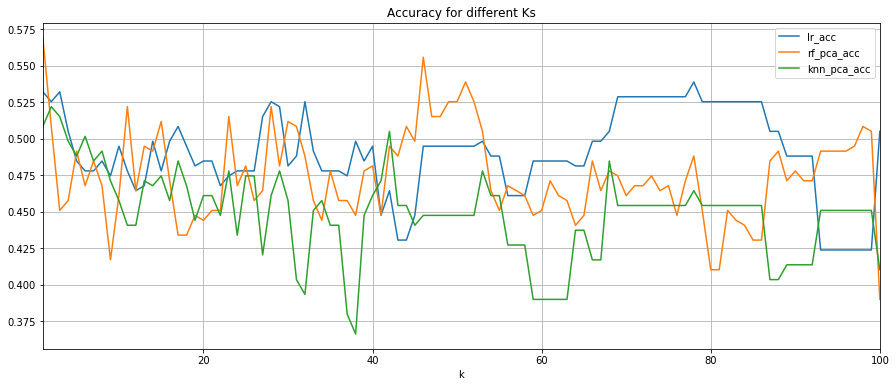

In [28]:
accs.plot("k", ["lr_acc", "rf_pca_acc", "knn_pca_acc"], figsize=(15,6), grid=True, title="Accuracy for different Ks")
#plt.savefig("../figures/varying_k_birth_mondrian.png")